In [2]:
# 1. Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# 2. Download Spark from a reliable mirror
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz

# 3. Install findspark
!pip install -q findspark

# 4. Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

# 5. Initialize findspark and Spark session
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("YouTubeTrendingAnalysis").getOrCreate()

print("✅ PySpark is ready!")


✅ PySpark is ready!


In [28]:
from google.colab import files

# This will open a file upload dialog. Upload a file like 'INvideos.csv'
uploaded = files.upload()


Saving IN_category_id.json to IN_category_id.json


In [4]:
# Replace 'INvideos.csv' with your uploaded file's name if different
df = spark.read.csv('INvideos.csv', header=True, inferSchema=True)

# Show schema (columns and types)
df.printSchema()

# Show first 5 rows
df.show(5, truncate=False)


root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- video_error_or_removed: boolean (nullable = true)
 |-- description: string (nullable = true)

+-----------+-------------+----------------------------------------------------------------------------------------+---------------+-----------+------------------------+------------------------------------------------------------------------------------------------------------------------------------

In [5]:
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")


Total rows: 38528
Total columns: 16


In [6]:
from pyspark.sql.functions import col, sum as spark_sum

# Count nulls in each column
df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+
|video_id|trending_date|title|channel_title|category_id|publish_time|tags|views|likes|dislikes|comment_count|thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|description|
+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+
|       0|          911|  993|         1106|       1139|        1152|1164| 1172| 1174|    1176|         1177|          1177|             1177|            1177|                  1177|       1738|
+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+



In [9]:
# Check unique categories
df.select("category_id").distinct().show()

# Check unique channel names
df.select("channel_title").distinct().limit(10).show()


+--------------------+
|         category_id|
+--------------------+
|          festivals |
|                  15|
|                  29|
|                  30|
| जैसे ही विकेट का...|
|                  22|
|                  28|
| పెళ్లి అంటూ సంధ్...|
|                null|
|                  43|
| ಸಂಯುಕ್ತ 'ಬಿಗ್ ಬಾ...|
|                  27|
|                  17|
|                  26|
|                  19|
|                  23|
| దర్యాప్తు చేస్తు...|
|                  25|
| ராகவேந்திரா மண்ட...|
| Subscribe▬▬▬▬▬▬▬...|
+--------------------+
only showing top 20 rows

+------------------+
|     channel_title|
+------------------+
|   DREAMS N BEYOND|
|Natural HealthCare|
|            And TV|
|  Gaurav Chaudhary|
|   Telugucine Buzz|
|  Hi Speed Records|
|Nee Yaaruda Komali|
|         NYOOOZ TV|
|    The Timeliners|
|    Brijnaari Sumi|
+------------------+



In [10]:
from pyspark.sql.functions import to_timestamp, to_date, col, concat_ws

# Fix publish_time (already ISO 8601 format)
df = df.withColumn("publish_time_ts", to_timestamp("publish_time"))

# Fix trending_date (convert 'yy.dd.mm' to 'yyyy-mm-dd')
# We'll rearrange it into yyyy-mm-dd using substring
from pyspark.sql.functions import expr

df = df.withColumn("trending_date_fmt", expr("""
  to_date(concat_ws('-', '20' || substring(trending_date, 1, 2),
                             substring(trending_date, 7, 2),
                             substring(trending_date, 4, 2)), 'yyyy-MM-dd')
"""))


In [11]:
from pyspark.sql.functions import hour, datediff

df = df.withColumn("publish_hour", hour("publish_time_ts"))
df = df.withColumn("days_to_trend", datediff("trending_date_fmt", to_date("publish_time_ts")))


In [12]:
df_clean = df.drop("thumbnail_link", "description",
                   "video_error_or_removed", "comments_disabled",
                   "ratings_disabled")


In [13]:
df_clean = df_clean.na.drop(subset=["views", "likes", "trending_date_fmt", "publish_time_ts"])


In [14]:
df_clean.printSchema()
df_clean.show(5, truncate=False)


root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- publish_time_ts: timestamp (nullable = true)
 |-- trending_date_fmt: date (nullable = true)
 |-- publish_hour: integer (nullable = true)
 |-- days_to_trend: integer (nullable = true)

+-----------+-------------+----------------------------------------------------------------------------------------+---------------+-----------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
from pyspark.sql.functions import sum as spark_sum

# Group by video ID and title, sum their views across trending days
top_viewed_videos = df_clean.groupBy("video_id", "title", "channel_title") \
    .agg(spark_sum("views").alias("total_trending_views")) \
    .orderBy(col("total_trending_views").desc())

top_viewed_videos.show(10, truncate=False)


+-----------+----------------------------------------------------------------------------------------------+---------------------------+--------------------+
|video_id   |title                                                                                         |channel_title              |total_trending_views|
+-----------+----------------------------------------------------------------------------------------------+---------------------------+--------------------+
|6ZfuNTqbHE8|Marvel Studios' Avengers: Infinity War Official Trailer                                       |Marvel Entertainment       |5.77552394E8        |
|rRr1qiJRsXk|Sanju | Official Teaser | Ranbir Kapoor | Rajkumar Hirani                                     |FoxStarHindi               |5.67760602E8        |
|u9Mv98Gr5pY|VENOM - Official Trailer (HD)                                                                 |Sony Pictures Entertainment|5.33860734E8        |
|FlsCjmMhFmw|YouTube Rewind: The Shape of 2017 | #Yo

In [18]:
from pyspark.sql.functions import count

longest_trending = df_clean.groupBy("video_id", "title", "channel_title") \
    .agg(count("*").alias("days_on_trending")) \
    .orderBy(col("days_on_trending").desc())

longest_trending.show(10, truncate=False)


+-----------+----------------------------------------------------------------------------------------------------+-----------------------+----------------+
|video_id   |title                                                                                               |channel_title          |days_on_trending|
+-----------+----------------------------------------------------------------------------------------------------+-----------------------+----------------+
|rRr1qiJRsXk|Sanju | Official Teaser | Ranbir Kapoor | Rajkumar Hirani                                           |FoxStarHindi           |16              |
|1J76wN0TPI4|Sanju | Official Trailer | Ranbir Kapoor | Rajkumar Hirani | Releasing on 29th June                 |FoxStarHindi           |14              |
|l7E0kTvARsA|Golak Bugni Bank Te Batua Full Movie (HD) | Harish Verma | Simi Chahal | Superhit Punjabi Movies    |Rhythm Boyz            |14              |
|bYSRPuDEnTg|Garmi Ke Side-Effects | Ashish Chanchlani          

In [19]:
from pyspark.sql.functions import avg, round

# Group by hour of publish and calculate average views
views_by_hour = df_clean.groupBy("publish_hour") \
    .agg(round(avg("views"), 0).alias("avg_views")) \
    .orderBy("publish_hour")

views_by_hour.show(24)


+------------+---------+
|publish_hour|avg_views|
+------------+---------+
|           0| 697563.0|
|           1|1252534.0|
|           2| 765113.0|
|           3|1173203.0|
|           4|1276174.0|
|           5|1270203.0|
|           6|1110944.0|
|           7|1312904.0|
|           8| 898996.0|
|           9| 915635.0|
|          10| 808551.0|
|          11| 755874.0|
|          12|1155865.0|
|          13|1577058.0|
|          14| 943189.0|
|          15| 737590.0|
|          16| 851242.0|
|          17|1052396.0|
|          18|1324984.0|
|          19|1087207.0|
|          20|1049459.0|
|          21|1499418.0|
|          22|1232885.0|
|          23| 725234.0|
+------------+---------+



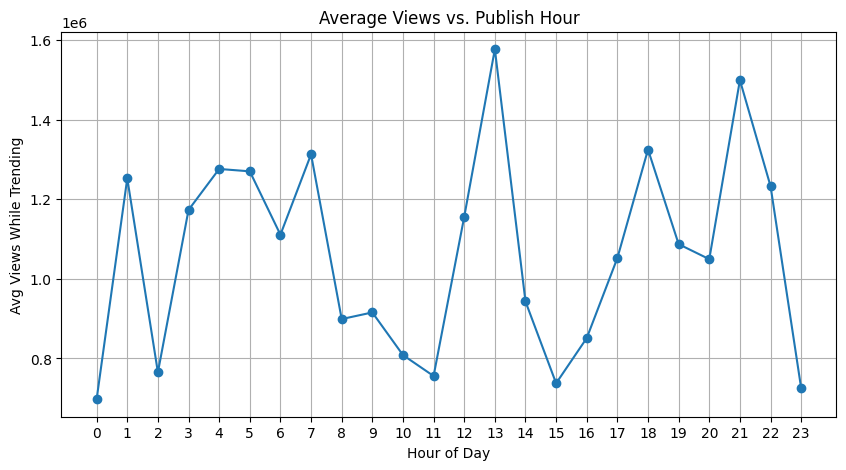

In [20]:
# Convert Spark DataFrame to Pandas for plotting
pdf = views_by_hour.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(pdf['publish_hour'], pdf['avg_views'], marker='o')
plt.title("Average Views vs. Publish Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Views While Trending")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


In [21]:
from pyspark.sql.functions import avg

# Average time to trend
df_clean.select(avg("days_to_trend")).show()


+------------------+
|avg(days_to_trend)|
+------------------+
| 2.087494310727959|
+------------------+



In [23]:
df_clean.groupBy("days_to_trend") \
    .count() \
    .orderBy("days_to_trend") \
    .show(30)


+-------------+-----+
|days_to_trend|count|
+-------------+-----+
|            0|  528|
|            1|14042|
|            2|11989|
|            3| 6272|
|            4| 2867|
|            5| 1183|
|            6|  319|
|            7|   83|
|            8|   22|
|            9|    8|
|           10|    7|
|           11|    9|
|           12|    7|
|           13|    3|
|           14|    1|
|           15|    4|
|           18|    1|
|           33|    1|
|           49|    1|
|           50|    1|
|           51|    1|
|          220|    1|
|          221|    1|
+-------------+-----+



In [24]:
# Convert to Pandas for plotting
days_df = df_clean.select("days_to_trend").dropna().toPandas()


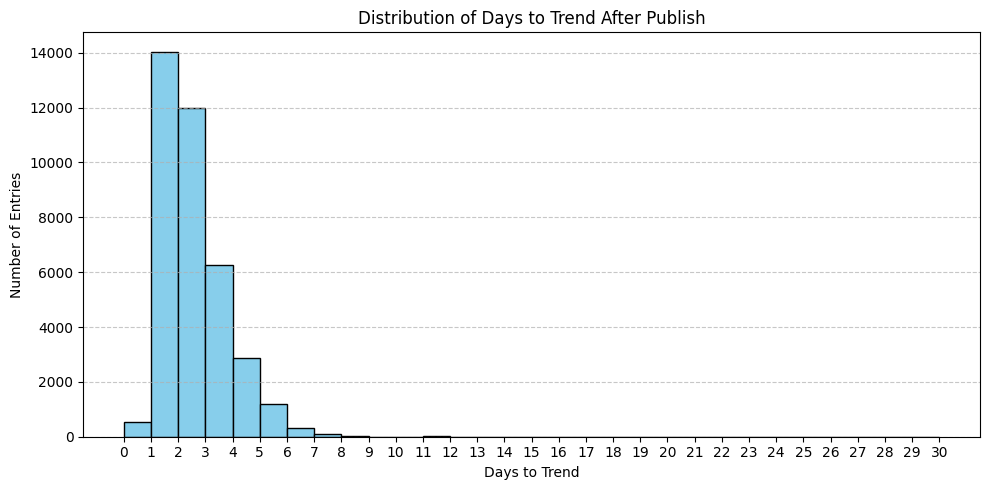

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(days_df["days_to_trend"], bins=range(0, 31), color="skyblue", edgecolor="black")
plt.title("Distribution of Days to Trend After Publish")
plt.xlabel("Days to Trend")
plt.ylabel("Number of Entries")
plt.xticks(range(0, 31))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [27]:
from pyspark.sql.functions import count

top_channels = df_clean.groupBy("channel_title") \
    .agg(count("*").alias("trending_count")) \
    .orderBy(col("trending_count").desc())

top_channels.show(10, truncate=False)


+----------------+--------------+
|channel_title   |trending_count|
+----------------+--------------+
|VikatanTV       |284           |
|etvteluguindia  |282           |
|Flowers Comedy  |270           |
|ETV Plus India  |253           |
|SAB TV          |244           |
|RadaanMedia     |243           |
|SET India       |238           |
|mallemalatv     |238           |
|ETV Jabardasth  |234           |
|Vijay Television|231           |
+----------------+--------------+
only showing top 10 rows



In [35]:
# 🛠️ Read the JSON properly as multiline
category_raw_df = spark.read.option("multiline", "true").json("IN_category_id.json")

# Check schema now — should show 'items'
category_raw_df.printSchema()
category_raw_df.select("items").show(1, truncate=False)


root
 |-- etag: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- etag: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- kind: string (nullable = true)
 |    |    |-- snippet: struct (nullable = true)
 |    |    |    |-- assignable: boolean (nullable = true)
 |    |    |    |-- channelId: string (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |-- kind: string (nullable = true)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
from pyspark.sql.functions import explode, col

# Explode the array of category items
exploded = category_raw_df.select(explode("items").alias("item"))

# Extract categoryId and categoryTitle from nested structure
category_df = exploded.select(
    col("item.id").cast("int").alias("category_id"),
    col("item.snippet.title").alias("categoryTitle")
)

category_df.show()


+-----------+--------------------+
|category_id|       categoryTitle|
+-----------+--------------------+
|          1|    Film & Animation|
|          2|    Autos & Vehicles|
|         10|               Music|
|         15|      Pets & Animals|
|         17|              Sports|
|         18|        Short Movies|
|         19|     Travel & Events|
|         20|              Gaming|
|         21|       Videoblogging|
|         22|      People & Blogs|
|         23|              Comedy|
|         24|       Entertainment|
|         25|     News & Politics|
|         26|       Howto & Style|
|         27|           Education|
|         28|Science & Technology|
|         30|              Movies|
|         31|     Anime/Animation|
|         32|    Action/Adventure|
|         33|            Classics|
+-----------+--------------------+
only showing top 20 rows



In [40]:
df_with_cat = df_clean.join(category_df, on="category_id", how="left")

top_categories = df_with_cat.groupBy("categoryTitle") \
    .agg(count("*").alias("video_count")) \
    .orderBy(col("video_count").desc())

top_categories.show(truncate=False)


+--------------------+-----------+
|categoryTitle       |video_count|
+--------------------+-----------+
|Entertainment       |16712      |
|News & Politics     |5240       |
|Music               |3858       |
|Comedy              |3429       |
|People & Blogs      |2624       |
|Film & Animation    |1658       |
|Education           |1227       |
|Howto & Style       |845        |
|Sports              |731        |
|Science & Technology|552        |
|Shows               |205        |
|null                |105        |
|Autos & Vehicles    |72         |
|Gaming              |66         |
|Movies              |16         |
|Travel & Events     |8          |
|Pets & Animals      |3          |
+--------------------+-----------+



In [42]:
top_categories = df_with_cat.groupBy("categoryTitle") \
    .agg(count("*").alias("video_count")) \
    .orderBy(col("video_count").desc())


In [43]:
top_cat_pd = top_categories.toPandas()
top_5 = top_cat_pd.head(5)


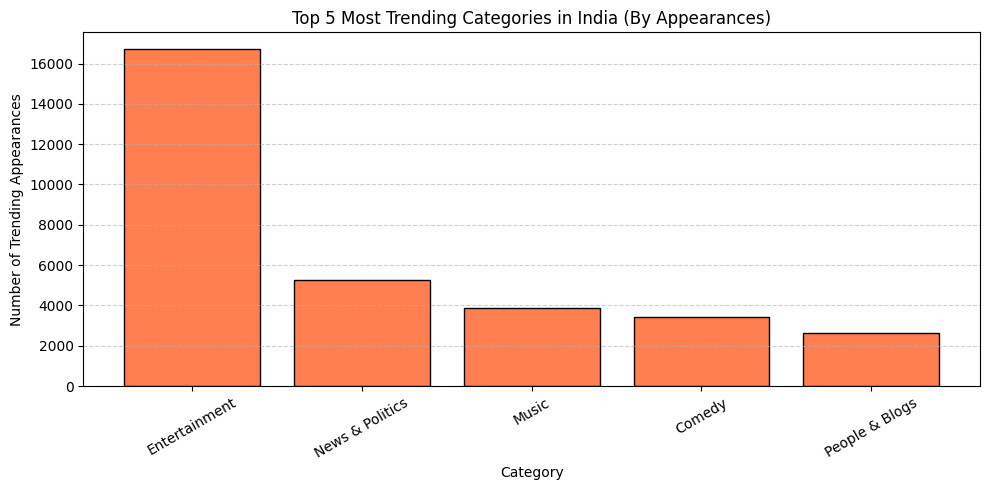

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(top_5["categoryTitle"], top_5["video_count"], color="coral", edgecolor="black")
plt.title("Top 5 Most Trending Categories in India (By Appearances)")
plt.xlabel("Category")
plt.ylabel("Number of Trending Appearances")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [45]:
views_by_category = df_with_cat.groupBy("categoryTitle") \
    .agg(round(avg("views"), 0).alias("avg_views")) \
    .orderBy(col("avg_views").desc())

views_by_category.show(10, truncate=False)

+--------------------+---------+
|categoryTitle       |avg_views|
+--------------------+---------+
|Gaming              |4162462.0|
|Movies              |3065001.0|
|Music               |2631116.0|
|Film & Animation    |2320356.0|
|Sports              |1887755.0|
|Pets & Animals      |1626581.0|
|Entertainment       |964600.0 |
|Howto & Style       |872596.0 |
|Science & Technology|864332.0 |
|Comedy              |842132.0 |
+--------------------+---------+
only showing top 10 rows



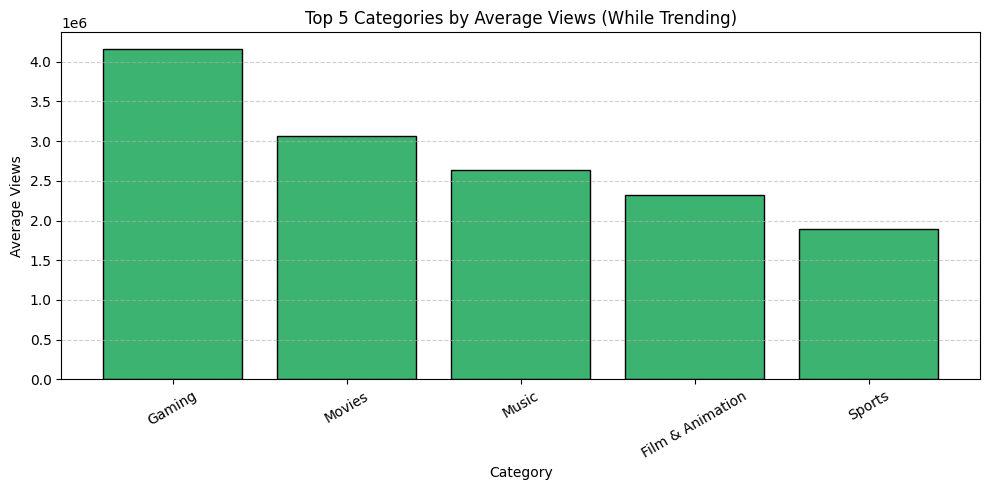

In [46]:
# Convert to Pandas and plot
views_cat_pd = views_by_category.toPandas()
top_5_views = views_cat_pd.head(5)

plt.figure(figsize=(10, 5))
plt.bar(top_5_views["categoryTitle"], top_5_views["avg_views"], color="mediumseagreen", edgecolor="black")
plt.title("Top 5 Categories by Average Views (While Trending)")
plt.xlabel("Category")
plt.ylabel("Average Views")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
